In [ ]:
# import sqlite3
# import pandas as pd
# import networkx as nx
# import matplotlib
# import matplotlib.pyplot as plt

# SQL_LITE_DB_PATH = "D:\\Repos\\ut-health\\mimic-iii-gz\\mimic3.db"
# CREATE_PYVIS_GRAPHS = False

# # connect to the SQLite database in the file at the given path d:\data\mimic.db
# conn = sqlite3.connect(SQL_LITE_DB_PATH)

# # print version of sqlite
# cursor = conn.cursor()
# cursor.execute("SELECT sqlite_version()")
# print(f"SQLite version: {cursor.fetchone()}")

# # close connection
# conn.close()

# # print versions
# print(f"Pandas version: {pd.__version__}")
# print(f"Matplotlib version: {matplotlib.__version__}")
# print(f"NetworkX version: {nx.__version__}")

# # set pandas display options to show all columns and rows without truncation
# pd.set_option('display.max_colwidth', None)
# pd.set_option('display.max_columns', None)
# print("\nRemoved truncation of columns")

SQLite version: ('3.49.1',)
Pandas version: 2.2.3
Matplotlib version: 3.10.1
NetworkX version: 3.4.2

Removed truncation of columns


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%ls

drive/  sample_data/


In [3]:
%cd drive/MyDrive/AI_in_Healthcare/high_risk_project/3_approach_HGNN/

/content/drive/MyDrive/AI_in_Healthcare/high_risk_project/3_approach_HGNN


In [4]:
# Import libraries
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path
import tensorflow as tf
import networkx as nx

# Below imports are used to print out pretty pandas dataframes
from IPython.display import display, HTML

In [5]:
# Imports data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

In [6]:
auth.authenticate_user()

In [7]:
from google.cloud import bigquery

# Set your Google Cloud Project ID here
project_id = "hw3inhea"  # Replace with your project ID

# Set the project ID in BigQuery client
client = bigquery.Client(project=project_id)

In [8]:
def run_query(query):
  return pd.io.gbq.read_gbq(
      query,
      project_id=project_id,
      dialect='standard')

# Load Data

In [9]:
# load patient data
# conn = sqlite3.connect(SQL_LITE_DB_PATH)

# query = "SELECT * FROM patients"
# patients_df = pd.read_sql_query(query, conn)

# query = "SELECT * FROM d_icd_diagnoses"
# d_icd_diagnoses_df = pd.read_sql_query(query, conn)

# query = "SELECT * FROM diagnoses_icd"
# diagnoses_icd_df = pd.read_sql_query(query, conn)

# query = "SELECT * FROM admissions"
# admissions_df = pd.read_sql_query(query, conn)

# query = "SELECT * FROM procedures_icd"
# procedures_icd_df = pd.read_sql_query(query, conn)

# query = "SELECT * FROM d_icd_procedures"
# d_icd_procedures_df = pd.read_sql_query(query, conn)

# conn.close()

patients_df = run_query("""
SELECT * FROM `physionet-data.mimiciii_clinical.patients`
""")

d_icd_diagnoses_df = run_query("""
SELECT * FROM `physionet-data.mimiciii_clinical.d_icd_diagnoses`
""")

diagnoses_icd_df = run_query("""
SELECT * FROM `physionet-data.mimiciii_clinical.diagnoses_icd`
""")

admissions_df = run_query("""
SELECT * FROM `physionet-data.mimiciii_clinical.admissions`
""")

procedures_icd_df = run_query("""
SELECT * FROM `physionet-data.mimiciii_clinical.procedures_icd`
""")

d_icd_procedures_df = run_query("""
SELECT * FROM `physionet-data.mimiciii_clinical.d_icd_procedures`
""")

<ipython-input-8-c095cac42290>:2: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  return pd.io.gbq.read_gbq(


# Downsample to reduce data size
Reduces the number of patients, picks the latest admission (hadm_id) for the patient and picks only those diagnoses belonging to the hospital admission.

In [10]:
procedures_icd_df.rename(columns=str.upper, inplace=True)
procedures_icd_df.head(2)

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,841,256,155415,1,3971
1,842,256,155415,2,3979


In [11]:
# print the number of patients and diagnoses
print(f"Patients count: {len(patients_df)}")
print(f"Admissions count: {len(admissions_df)}")
print(f"Diagnoses count: {len(diagnoses_icd_df)}")
print(f"Procedures count: {len(procedures_icd_df)}")

# patient fraction of the full 46k patient dataframe to select for processing
pt_frac = 0.0001  # gives 5 patients, 52 diagnoses
pt_frac = 0.0002  # gives 9 patients, 110 diagnoses
pt_frac = 0.0003  # gives 14 patients, 188 diagnoses
pt_frac = 0.0015  # gives 70 patients, 813 diagnoses
pt_frac = 0.01    # gives 465 patients, 5085 diagnoses
pt_frac = 0.02    # gives 930 patients, 9939 diagnoses
pt_frac = 0.05    # gives 2326 patients, 24959 diagnoses
pt_frac = 0.25    # gives 11630 patients, 124000 diagnoses

pt_frac = 0.38 # 38% 41868 patient data

# select 0.01% of the patients randomly
patients_df = patients_df.sample(frac=pt_frac, random_state=1)

# merge with admissions and add DOB to admissions_df
admissions_df = admissions_df.merge(patients_df[['SUBJECT_ID', 'DOB']], left_on='SUBJECT_ID', right_on='SUBJECT_ID', how='inner', suffixes=('_adm', '_pt'))

# sort admissions_df by SUBJECT_ID and ADMITTIME in ascending order
admissions_df['ADMITTIME'] = pd.to_datetime(admissions_df['ADMITTIME'])
admissions_df = admissions_df.sort_values(by=['SUBJECT_ID', 'ADMITTIME'])

# keep the newest admission (HADM_ID) for each patient, drop the rest of the admissions
admissions_df = admissions_df.groupby('SUBJECT_ID').last().reset_index()

# keep only diagnoses that belong to HADM_IDs in admissions_df
diagnoses_icd_df = diagnoses_icd_df[diagnoses_icd_df['HADM_ID'].isin(admissions_df['HADM_ID'])]

# keep only procedures that belong to HADM_IDs in admissions_df
procedures_icd_df = procedures_icd_df[procedures_icd_df['HADM_ID'].isin(admissions_df['HADM_ID'])]

# print the number of patients and diagnoses
print(f"Updated patient count: {len(patients_df)}")
print(f"Updated admissions count: {len(admissions_df)}")
print(f"Updated diagnoses count: {len(diagnoses_icd_df)}, unique diagnoses: {len(diagnoses_icd_df['ICD9_CODE'].unique())}")
print(f"Updated procedures count: {len(procedures_icd_df)}, unique procedures: {len(procedures_icd_df['ICD9_CODE'].unique())}")

Patients count: 46520
Admissions count: 58976
Diagnoses count: 651047
Procedures count: 240095
Updated patient count: 17678
Updated admissions count: 17678
Updated diagnoses count: 189708, unique diagnoses: 5184
Updated procedures count: 70797, unique procedures: 1508


# Feature Engineering
Create age bucket and add hadm_id to patients dataframe

In [12]:
admissions_df.rename(columns=str.upper, inplace=True)
admissions_df.head(2)

,SUBJECT_ID,ROW_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,DOB
0,6,5,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,NaT,NaT,CHRONIC RENAL FAILURE/SDA,0,1,2109-06-21
1,7,6,118037,2121-05-23 15:05:00,2121-05-27 11:57:00,NaT,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,None,CATHOLIC,None,WHITE,NaT,NaT,NEWBORN,0,1,2121-05-23


In [13]:
print(f"Patient count: {len(patients_df)}")

# convert to integer from datetime type to calculate age (without overflow)
admissions_df['DOB'] = admissions_df['DOB'].astype('datetime64[s]').astype(int)
admissions_df['ADMITTIME'] = admissions_df['ADMITTIME'].astype('datetime64[s]').astype(int)

# calculate age at admission
admissions_df['AGE'] = (admissions_df['ADMITTIME'] - admissions_df['DOB']) / 86400 / 365

# create age intervals in 5 year increments, of type int
admissions_df['AGE_BUCKET'] = (admissions_df['AGE'] // 5).astype(int) * 5

# set age bucket to 95 where age is greater than 90
admissions_df.loc[admissions_df['AGE_BUCKET'] > 90, 'AGE_BUCKET'] = 95

# add AGE_BUCKET to patients_df
patients_df = patients_df.merge(admissions_df[['SUBJECT_ID', 'HADM_ID', 'AGE_BUCKET']], left_on='SUBJECT_ID', right_on='SUBJECT_ID', how='inner', suffixes=('_pt', '_adm'))

# keep only the relevant columns in patients_df
patients_df = patients_df[['SUBJECT_ID', 'HADM_ID', 'GENDER', 'AGE_BUCKET', 'EXPIRE_FLAG']]

print(f"Updated patient count (with age bucket): {len(patients_df)}")

Patient count: 17678
Updated patient count (with age bucket): 17678


# Create network graph

## Create nodes: patients

In [14]:
# Create a graph
G = nx.MultiGraph()
print(f"Nodes count in graph: {G.number_of_nodes()}")

for _, row in patients_df.iterrows():

    # Add a node with the patient ID as the node identifier and gender as an attribute, also add dob as an attribute
    G.add_node(f"patient-{row['SUBJECT_ID']}", gender=row['GENDER'], age_bucket=row['AGE_BUCKET'], hadm_id=row['HADM_ID'], type='patient')

# number of nodes in the graph
print(f"Updated node count in graph: {G.number_of_nodes()}")

Nodes count in graph: 0
Updated node count in graph: 17678


## Create nodes + edges: diagnoses and patient -> diagnoses

In [15]:
print(f"Diagnoses row count pre-merge: {len(diagnoses_icd_df)}")

# merge diagnoses with d_icd_diagnoses to get the description of the diagnosis
diagnoses_icd_df = diagnoses_icd_df.merge(d_icd_diagnoses_df[['ICD9_CODE', 'SHORT_TITLE']], left_on='ICD9_CODE', right_on='ICD9_CODE', how='left', suffixes=('_diag', '_desc'))

# Check if the merge was successful and print the number of rows in the merged DataFrame
print(f"Diagnoses row count post-merge: {len(diagnoses_icd_df)}")

Diagnoses row count pre-merge: 189708
Diagnoses row count post-merge: 189708


In [16]:
diagnoses_icd_df.head(2)

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,SHORT_TITLE
0,6035,512,102509,1,V3101,Twin-mate lb-in hos w cs
1,6036,512,102509,2,76519,Preterm NEC 2500+g


In [17]:
# number of nodes in the graph
n_count = G.number_of_nodes()
print(f"Node count in graph: {n_count}")

# do an inplace sort asending by HADM_ID and SEQ_NUM
diagnoses_icd_df.sort_values(by=['HADM_ID', 'SEQ_NUM'], inplace=True)
i=0
# Create nodes for diagnoses and connect them to patients
for _, row in diagnoses_icd_df.iterrows():

    # create unique name to prevent clashes with other node id
    diag_node_id = f'diagnosis-{row["ICD9_CODE"]}'

    # add the diagnosis as a node
    if not G.has_node(diag_node_id):
        G.add_node(diag_node_id, name=row['SHORT_TITLE'], code=row['ICD9_CODE'], type='diagnosis')

    # Connect the patient to this diagnosis
    patient_id = f"patient-{row['SUBJECT_ID']}"
    G.add_edge(patient_id, diag_node_id, relation='has_diagnosis', seq_num=row['SEQ_NUM'])

# Print updated graph stats
print(f"Diagnosis nodes added: {G.number_of_nodes() - n_count}")
print(f"Edges count in graph: {G.number_of_edges()}")
print(f"Updated node count in graph: {G.number_of_nodes()}")

Node count in graph: 17678
Diagnosis nodes added: 5184
Edges count in graph: 189708
Updated node count in graph: 22862


## Create nodes + edges: procedures and patient -> procedures

In [18]:
procedures_icd_df.head(2)

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
9,118029,512,102509,1,9955
10,60069,768,170167,1,5459


In [19]:
d_icd_procedures_df.head(2)

,row_id,icd9_code,short_title,long_title
0,264,0851,Canthotomy,Canthotomy
1,265,0852,Blepharorrhaphy,Blepharorrhaphy


In [20]:
d_icd_procedures_df.rename(columns=str.upper, inplace=True)
d_icd_procedures_df.head(2)

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,264,0851,Canthotomy,Canthotomy
1,265,0852,Blepharorrhaphy,Blepharorrhaphy


In [21]:
# count before merge
print(f"Procedures count pre-merge: {len(procedures_icd_df)}")

# merge procedures with d_icd_procedures to get the description of the procedure
procedures_icd_df = procedures_icd_df.merge(d_icd_procedures_df[['ICD9_CODE', 'SHORT_TITLE']], left_on='ICD9_CODE', right_on='ICD9_CODE', how='left', suffixes=('_proc', '_desc'))

print(f"Procedures count post-merge: {len(procedures_icd_df)}")

Procedures count pre-merge: 70797
Procedures count post-merge: 70797


In [22]:
# number of nodes in the graph before adding procedures
n_count = G.number_of_nodes()
print(f"Node count in graph before adding procedures: {n_count}")

# do an inplace sort ascending by HADM_ID and SEQ_NUM
procedures_icd_df.sort_values(by=['HADM_ID', 'SEQ_NUM'], inplace=True)

# Create nodes for procedures and connect them to patients
for _, row in procedures_icd_df.iterrows():
    # create unique name to prevent clashes with other node ids
    proc_node_id = f'procedure-{row["ICD9_CODE"]}'

    # add the procedure as a node if it doesn't already exist
    if not G.has_node(proc_node_id):
        G.add_node(proc_node_id, name=row['SHORT_TITLE'], code=row['ICD9_CODE'], type='procedure')

    # Connect the patient to this procedure
    patient_id = f"patient-{row['SUBJECT_ID']}"
    G.add_edge(patient_id, proc_node_id, relation='has_procedure', seq_num=row['SEQ_NUM'])

# Print updated graph stats
print(f"Procedure nodes added: {G.number_of_nodes() - n_count}")
print(f"Edges count in graph: {G.number_of_edges()}")
print(f"Updated node count in graph: {G.number_of_nodes()}")

Node count in graph before adding procedures: 22862
Procedure nodes added: 1508
Edges count in graph: 260505
Updated node count in graph: 24370


# Network Graph Statistics

In [23]:
# print the number of each type of node
node_types = {data.get('type'): 0 for _, data in G.nodes(data=True)}
for _, data in G.nodes(data=True):
    node_type = data.get('type')
    node_types[node_type] += 1

print("Node counts by type:")
for node_type, count in node_types.items():
    print(f"\t{node_type}: {count}")

# print edge types
edge_types = {data.get('relation'): 0 for _, _, data in G.edges(data=True)}
for _, _, data in G.edges(data=True):
    edge_type = data.get('relation')
    edge_types[edge_type] += 1

print("\nEdge counts by type:")
for edge_type, count in edge_types.items():
    print(f"\t{edge_type}: {count}")

Node counts by type:
	patient: 17678
	diagnosis: 5184
	procedure: 1508

Edge counts by type:
	has_diagnosis: 189708
	has_procedure: 70797


# Create Similarity Data
Similarity data is used as the validation set by R-GCN neural networks

## Jaccard Similarity

Total patient nodes: 17678
Total diagnosis nodes: 5184
Total procedure nodes: 1508
Diagnosis matrix shape: (17678, 5184)
Procedure matrix shape: (17678, 1508)
Combined matrix shape: (17678, 6692)

Combined Features Similarity Data Summary:
Total pairs analyzed: 156247003
Positive pairs (similar patients): 1356810
Negative pairs (dissimilar patients): 1356810
Final validation set size: 2713620

Similarity Distribution:


/usr/local/lib/python3.11/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.11/dist-packages/pandas/core/nanops.py:731: RuntimeWarning: invalid value encountered in scalar divide
  the_mean = the_sum / count if count > 0 else np.nan
/usr/local/lib/python3.11/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)


count    1.562470e+08
mean              NaN
std      0.000000e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      4.165649e-02
max      1.000000e+00
Name: jaccard_similarity, dtype: float64


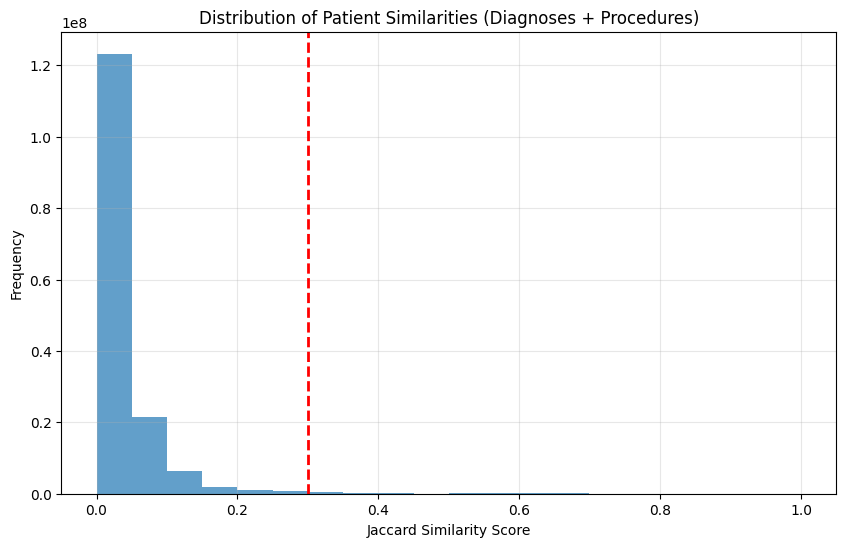


Combined features validation data ready for model evaluation


In [24]:
import pandas as pd
import numpy as np
from scipy import sparse

# Get all patient nodes and their connected diagnoses and procedures
patient_nodes = [node for node, data in G.nodes(data=True) if data.get('type') == 'patient']
diagnosis_nodes = [node for node, data in G.nodes(data=True) if data.get('type') == 'diagnosis']
procedure_nodes = [node for node, data in G.nodes(data=True) if data.get('type') == 'procedure']

print(f"Total patient nodes: {len(patient_nodes)}")
print(f"Total diagnosis nodes: {len(diagnosis_nodes)}")
print(f"Total procedure nodes: {len(procedure_nodes)}")

# Create mapping from node IDs to indices for efficient lookup
patient_to_idx = {patient: i for i, patient in enumerate(patient_nodes)}
diagnosis_to_idx = {diagnosis: i for i, diagnosis in enumerate(diagnosis_nodes)}
procedure_to_idx = {procedure: i for i, procedure in enumerate(procedure_nodes)}

# Create sparse matrices for patient-diagnosis and patient-procedure connections
# For diagnoses
diag_rows, diag_cols = [], []
for patient in patient_nodes:
    for neighbor in G.neighbors(patient):
        if 'diagnosis' in neighbor:
            diag_rows.append(patient_to_idx[patient])
            diag_cols.append(diagnosis_to_idx[neighbor])

# For procedures
proc_rows, proc_cols = [], []
for patient in patient_nodes:
    for neighbor in G.neighbors(patient):
        if 'procedure' in neighbor:
            proc_rows.append(patient_to_idx[patient])
            proc_cols.append(procedure_to_idx[neighbor])

# Create sparse matrices
diag_data = np.ones(len(diag_rows), dtype=np.int8)
diag_matrix = sparse.csr_matrix((diag_data, (diag_rows, diag_cols)),
                              shape=(len(patient_nodes), len(diagnosis_nodes)))

proc_data = np.ones(len(proc_rows), dtype=np.int8)
proc_matrix = sparse.csr_matrix((proc_data, (proc_rows, proc_cols)),
                              shape=(len(patient_nodes), len(procedure_nodes)))

# Combine the two matrices horizontally for a unified feature representation
combined_matrix = sparse.hstack([diag_matrix, proc_matrix])

print(f"Diagnosis matrix shape: {diag_matrix.shape}")
print(f"Procedure matrix shape: {proc_matrix.shape}")
print(f"Combined matrix shape: {combined_matrix.shape}")

# Calculate dot product for intersection
intersection = combined_matrix.dot(combined_matrix.T)

# Compute features per patient (sum of diagnoses and procedures)
patient_feature_counts = np.array(combined_matrix.sum(axis=1)).flatten()

# Calculate jaccard similarities
intersection_dense = intersection.toarray()
union_dense = np.zeros_like(intersection_dense, dtype=np.float16)

for i in range(len(patient_nodes)):
    for j in range(i, len(patient_nodes)):  # Upper triangular is enough due to symmetry
        union_value = patient_feature_counts[i] + patient_feature_counts[j] - intersection_dense[i, j]
        union_dense[i, j] = union_value
        union_dense[j, i] = union_value  # Matrix is symmetric

# Calculate Jaccard similarity (intersection / union)
jaccard_matrix = np.zeros_like(intersection_dense, dtype=np.float16)
nonzero_mask = union_dense > 0
jaccard_matrix[nonzero_mask] = intersection_dense[nonzero_mask] / union_dense[nonzero_mask]

# Get patient data for additional metrics
patient_info = {}
for patient in patient_nodes:
    subject_id = int(patient.split('-')[1])
    patient_data = patients_df[patients_df['SUBJECT_ID'] == subject_id].iloc[0]
    patient_info[patient] = {
        'gender': patient_data['GENDER'],
        'age_bucket': patient_data['AGE_BUCKET']
    }

# Create DataFrame from similarity matrix
similarity_data = []
for i in range(len(patient_nodes)):
    for j in range(i+1, len(patient_nodes)):  # Only upper triangle to avoid duplicates
        p1 = patient_nodes[i]
        p2 = patient_nodes[j]
        p1_id = int(p1.split('-')[1])
        p2_id = int(p2.split('-')[1])

        # Get similarity score
        sim_score = jaccard_matrix[i, j]

        # Check if they have the same gender and age bucket
        same_gender = patient_info[p1]['gender'] == patient_info[p2]['gender']
        same_age_bucket = patient_info[p1]['age_bucket'] == patient_info[p2]['age_bucket']

        similarity_data.append({
            'patient1': p1,
            'patient2': p2,
            'patient1_id': p1_id,
            'patient2_id': p2_id,
            'jaccard_similarity': sim_score,
            'same_gender': same_gender,
            'same_age_bucket': same_age_bucket
        })

# Convert to DataFrame
combined_similarity_df = pd.DataFrame(similarity_data)

# Define positive and negative pairs based on similarity threshold
similarity_threshold = 0.3
combined_similarity_df['is_similar'] = combined_similarity_df['jaccard_similarity'] >= similarity_threshold

# Create validation sets
positive_pairs = combined_similarity_df[combined_similarity_df['is_similar']].copy()
negative_pairs = combined_similarity_df[~combined_similarity_df['is_similar']].copy()

# Balance the dataset
min_count = min(len(positive_pairs), len(negative_pairs))
if min_count < len(positive_pairs):
    positive_pairs = positive_pairs.sample(min_count, random_state=42)
if min_count < len(negative_pairs):
    negative_pairs = negative_pairs.sample(min_count, random_state=42)

# Combine into final validation set
validation_pairs_combined = pd.concat([positive_pairs, negative_pairs])

# Print summary statistics
print(f"\nCombined Features Similarity Data Summary:")
print(f"Total pairs analyzed: {len(combined_similarity_df)}")
print(f"Positive pairs (similar patients): {len(positive_pairs)}")
print(f"Negative pairs (dissimilar patients): {len(negative_pairs)}")
print(f"Final validation set size: {len(validation_pairs_combined)}")

# Show similarity distribution
print("\nSimilarity Distribution:")
print(combined_similarity_df['jaccard_similarity'].describe())

# Create a histogram of similarity scores
plt.figure(figsize=(10, 6))
plt.hist(combined_similarity_df['jaccard_similarity'], bins=20, alpha=0.7)
plt.axvline(similarity_threshold, color='red', linestyle='dashed', linewidth=2)
plt.title('Distribution of Patient Similarities (Diagnoses + Procedures)')
plt.xlabel('Jaccard Similarity Score')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

# Save combined validation pairs in CSV format
# validation_pairs_combined.to_csv('patient_similarity_combined_validation_pairs.csv', index=False)

print("\nCombined features validation data ready for model evaluation")

In [25]:
# show the last 5 rows of the validation pairs dataframe
validation_pairs_combined.head(5)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,patient1,patient2,patient1_id,patient2_id,jaccard_similarity,same_gender,same_age_bucket,is_similar
17680,patient-31182,patient-72623,31182,72623,0.333252,True,False,True
17777,patient-31182,patient-28675,31182,28675,0.300049,True,False,True
17810,patient-31182,patient-70605,31182,70605,0.312500,True,False,True
17877,patient-31182,patient-17208,31182,17208,0.333252,False,False,True
17967,patient-31182,patient-27351,31182,27351,0.353027,True,True,True


# Create Visual Pyvis Graph

In [26]:
import os

CURR_DIR_PATH = os.getcwd()
HTML_FILE_NAME = None

if G.number_of_nodes() < 10:
    HTML_FILE_NAME = f"graph_max_10_nodes.html"
elif G.number_of_nodes() < 50:
    HTML_FILE_NAME = f"graph_max_50_nodes.html"
elif G.number_of_nodes() < 100:
    HTML_FILE_NAME = f"graph_max_100_nodes.html"
elif G.number_of_nodes() < 1000:
    HTML_FILE_NAME = f"graph_max_1000_nodes.html"
elif G.number_of_nodes() < 10000:
    HTML_FILE_NAME = f"graph_max_10000_nodes.html"
elif G.number_of_nodes() < 15000:
    HTML_FILE_NAME = f"graph_max_15000_nodes.html"
elif G.number_of_nodes() < 20000:
    HTML_FILE_NAME = f"graph_max_20000_nodes.html"
else:
    HTML_FILE_NAME = f"graph_max_24370_nodes.html"

print(f"Total graph node count: {G.number_of_nodes()}")
print(f"HTML file name: {HTML_FILE_NAME}")

Total graph node count: 24370
HTML file name: graph_max_24370_nodes.html


In [27]:
!pip install pyvis


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 55.3 MB/s eta 0:00:00


In [28]:
ENABLE_PYVIS = True
MAX_NODES = 200

# if node count is less than MAX_NODES, create a pyvis graph
if ENABLE_PYVIS and G.number_of_nodes() < MAX_NODES:
    from pyvis.network import Network

    # Create a PyVis network
    net = Network(height="1200px", width="100%", notebook=False, directed=False, cdn_resources="remote")
    net.from_nx(G)

    # color patient nodes blue, diagnosis nodes green, and procedure nodes red
    for node in net.nodes:
        if 'patient' in node['id']:
            node['color'] = 'blue'
        elif 'diagnosis' in node['id']:
            node['color'] = 'green'
        elif 'procedure' in node['id']:
            node['color'] = 'red'


    # Show the graph in a notebook cell
    net.show_buttons()
    net.generate_html(HTML_FILE_NAME)
    net.save_graph(HTML_FILE_NAME)

    print(f"Graph saved to {HTML_FILE_NAME}")

# Pickle and persist

In [29]:
import os

CURR_DIR_PATH = os.getcwd()

PICKLE_GRAPH_FILE_NAME = None
PICKLE_SIMILARITY_FILE_NAME = None

if G.number_of_nodes() < 10:
    PICKLE_GRAPH_FILE_NAME = f"max_10_nodes_graph.gpickle"
    PICKLE_SIMILARITY_FILE_NAME = f"max_10_nodes_graph.gpickle"

elif G.number_of_nodes() < 50:
    PICKLE_GRAPH_FILE_NAME = f"max_50_nodes_graph.gpickle"
    PICKLE_SIMILARITY_FILE_NAME = f"max_50_nodes_similarity.gpickle"

elif G.number_of_nodes() < 100:
    PICKLE_GRAPH_FILE_NAME = f"max_100_nodes_graph.gpickle"
    PICKLE_SIMILARITY_FILE_NAME = f"max_100_nodes_similarity.gpickle"

elif G.number_of_nodes() < 1000:
    PICKLE_GRAPH_FILE_NAME = f"max_1000_nodes_graph.gpickle"
    PICKLE_SIMILARITY_FILE_NAME = f"max_1000_nodes_similarity.gpickle"

elif G.number_of_nodes() < 10000:
    PICKLE_GRAPH_FILE_NAME = f"max_10000_nodes_graph.gpickle"
    PICKLE_SIMILARITY_FILE_NAME = f"max_10000_nodes_similarity.gpickle"

elif G.number_of_nodes() < 15000:
    PICKLE_GRAPH_FILE_NAME = f"max_15000_nodes_graph.gpickle"
    PICKLE_SIMILARITY_FILE_NAME = f"max_15000_nodes_similarity.gpickle"

elif G.number_of_nodes() < 20000:
    PICKLE_GRAPH_FILE_NAME = f"max_20000_nodes_graph.gpickle"
    PICKLE_SIMILARITY_FILE_NAME = f"max_20000_nodes_similarity.gpickle"

else:
    PICKLE_GRAPH_FILE_NAME = f"max_24370_nodes_graph.gpickle"
    PICKLE_SIMILARITY_FILE_NAME = f"max_24370_nodes_similarity.gpickle"

print(f"Total graph node count: {G.number_of_nodes()}")
print(f"Pickle graph file name: {PICKLE_GRAPH_FILE_NAME}")
print(f"Pickle similarity file name: {PICKLE_SIMILARITY_FILE_NAME}")

Total graph node count: 24370
Pickle graph file name: max_24370_nodes_graph.gpickle
Pickle similarity file name: max_24370_nodes_similarity.gpickle


## Network Graph and Similarity Dataframe

In [30]:
print(PICKLE_GRAPH_FILE_NAME)


max_24370_nodes_graph.gpickle


In [31]:
# pickle the graph G
import pickle
with open(PICKLE_GRAPH_FILE_NAME, 'wb') as f:
    pickle.dump(G, f)
    print(f"Graph G pickled to {PICKLE_GRAPH_FILE_NAME}")

# pickle the positive similarity pairs
with open(PICKLE_SIMILARITY_FILE_NAME, 'wb') as f:
    pickle.dump(validation_pairs_combined, f)
    print(f"Similarity dataframe pickled to {PICKLE_SIMILARITY_FILE_NAME}")


Graph G pickled to max_24370_nodes_graph.gpickle
Similarity dataframe pickled to max_24370_nodes_similarity.gpickle
